# 1. Introduction

#### Unfortunately, credit card fraud occurs everyday all over the world. However, credit card companies have made significant progress in detecting these occurences in order to protect their customers. This dataset contains credit card transactions made in September 2013 in Europe over two days.

#### The goal of this notebook is to detect fraud and predict when they could occur. 

 # 2. Importing Libraries and Data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn import metrics

from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.express as px

import seaborn as sns
import random

In [ ]:
df_train_original = pd.read_csv(r"spam_dataset.csv")

df_train_original.drop(df_train_original.columns[0], axis=1, inplace=True)

df_test_original = pd.read_csv(r"spam_dataset.csv")

df_test_original.drop(df_test_original.columns[0], axis=1, inplace=True)

# In order to seperate test and training subsets later on in the notebook
df_original = pd.concat([df_train_original,df_test_original], axis = 0)

In [7]:
# Define the proportion of the sample size we want
sample_size = 0.15  

# Performing stratified sampling
df, _ = train_test_split(df_train_original, test_size=1-sample_size, random_state=42)

# Displaying the sampled DataFrame
df.shape

(150, 1)

# 3. EDA

## 3.1 Data Description
#### We'll first create a custom function that shows us the data type, % missing data, and number of unique values for each feature in the dataframe

In [8]:
def df_explore(df):
    missing = pd.DataFrame((df.isna().sum()/df.shape[0])*100).reset_index().rename(columns={'index': 'column',0:'%_missing'}).sort_values(by = '%_missing',ascending=False)
    nunique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index': 'column',0:'nunique'}).sort_values(by = 'nunique',ascending=False)
    dtypes = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index': 'column',0:'dtype'})
    return pd.merge(pd.merge(dtypes,missing,on='column'),nunique,on='column',how='left').sort_values(by='%_missing',ascending=False).sort_values(by = 'nunique', ascending = False)
print(df.shape)

df_explore(df).head(10)

(150, 1)


,column,dtype,%_missing,nunique
0,is_spam,int64,0.0,2


## 3.2 Data Balance Check
#### When dealing with binary target features, it's always good to determine if the data is balanced or not

Text(0.5, 1.0, '% of Fraudulent vs Non-fraudulent emails')

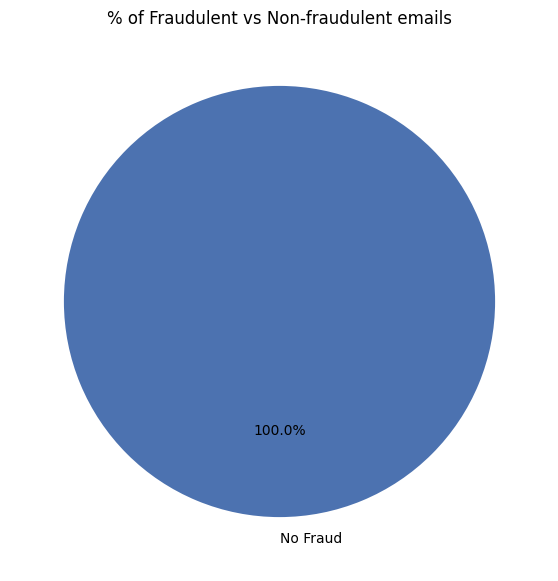

In [13]:
df['is_spam'] = df['is_spam'].apply(lambda x: "Fraud" if x==1 else "No Fraud")

is_spam_values = df['is_spam'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(is_spam_values, labels=is_spam_values.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("deep", n_colors=len(is_spam_values)))
plt.title('% of Fraudulent vs Non-fraudulent emails')

#### We can see that we have highly unbalanced data. This represents a severe skew in the class distribution. We have some methods to help alleviate this issue.

## 3.3 Fraud by Transaction Category

In [21]:
sns.countplot(x="message_content", data=df[df['is_spam']=="Spam"], palette="Set2", hue = 'category')

plt.title('Instances of Fraud by Transaction Category')
plt.xlabel('Transaction Category')
plt.ylabel('Count of Fraud Instance')
plt.xticks(rotation=45, ha = 'right')
plt.figure(figsize=(7, 7))
plt.show()

ValueError: Could not interpret value `message_content` for `x`. An entry with this name does not appear in `data`.

### 3.4 Fraud by Job

In [81]:
df[df['is_spam']=="Spam"]["message_content"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",x='message_content', y=df['is_spam']=="Spam", color=['red', 'green', 'blue', 'orange', 'purple'])
plt.title("Top of Credit Card Frauds by Job")
plt.show()

KeyError: 'message_content'

# 4. Data Pre-processing

## 4.1.1  Dropping duplicated values
#### A first simple step in cleaning the dataset is to remove any duplicate values

In [36]:
df2 = df.copy()

df2.drop_duplicates(inplace=True)

print("Duplicated values dropped")

Duplicated values dropped


## 4.1.2 Transforming Variables
#### Here we will check whether any variables can be easily transformed

#### Transforming the gender variable to be binary

In [80]:
def gender_transform(x):
    if x=='1':
        return 1
    if x=='0':
        return 0
df2['is_fraud'] = df2['is_fraud'].transform(gender_transform)

KeyError: 'is_fraud'

## 4.2 Dummy Variables

#### Continuing to process our data for a models, we'll take a look at the categorical data and their number of unique values to determine which we should retain for dummy variables 

In [48]:
df3 = df2.drop(['is_spam'],axis = 1)

In [62]:
# Ensure there are string columns to encode
string_cols = df3.select_dtypes('object')

if not string_cols.empty:
    df3_dummies = pd.get_dummies(string_cols)  # Remove dtype=int
    df4 = pd.concat([df3.drop(string_cols.columns, axis=1), df3_dummies], axis=1)
else:
    df4 = df3.copy()  # No categorical columns to encode

print(df4.shape)
print(df4.head())


(1, 0)
Empty DataFrame
Columns: []
Index: [32]


## 4.3 Stratified Train/Test split

#### We need to generate a training / validation dataset split that will keep the same percentages of classes in each split.

In [71]:
print(df4.columns)  # Check if 'is_spam' is present
df4 = df4.reset_index(drop=True)  # `drop` should be True, not 'index'
df4.columns = df4.columns.str.strip()  # Removes leading/trailing spaces

X = df4.drop(columns=['is_spam'], errors='ignore')  # Ignores missing columns


Index([], dtype='object')


In [78]:
df4 = df4.reset_index(drop=True)  # Fix reset_index()

print(df4.columns)  # Debugging step to check column names

if 'is_spam' in df4.columns:
    X = df4.drop('is_spam', axis=1)
    y = df4['is_spam']
else:
    print("Column 'is_spam' not found in df4")

if 'message_content' in df4.columns:
    y = df4['message_content']
else:
    print("Column 'message_content' not found in df4")

# Proceed only if both columns exist
if 'is_spam' in df4.columns and 'message_content' in df4.columns:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


Index([], dtype='object')
Column 'is_spam' not found in df4
Column 'message_content' not found in df4


In [77]:
X = df4.reset_index(drop='index').drop('is_fraud', axis=1)

y = df4.reset_index(drop='index')['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

KeyError: "['is_fraud'] not found in axis"

## 4.4 Feature Scaling

In [22]:
# Creating a function for scaling

def Standard_Scaler (df, col_names):

    features = df[col_names]

    scaler = StandardScaler().fit(features.values)

    features = scaler.transform(features.values)

    df[col_names] = features

    return df

col_names = ['amt']

X_train = Standard_Scaler (X_train, col_names)

X_test = Standard_Scaler (X_test, col_names)

NameError: name 'X_train' is not defined

# 5. Baseline Model (no imbalance resampling)

#### We'll start with building a baseline random forest model so we can have a reference in how the model performs if we left the data as is.

## 5.1 Random Forest

### 5.1.1 Instantiating the model 

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

### 5.1.2 Fitting the model

In [30]:
rf.fit(X_train, y_train)
y_pred_baseline = rf.predict(X_test)

NameError: name 'X_train' is not defined

### 5.1.3 Performance and Accuracy Scores

In [31]:
print("Performance with imbalanced dataset:")
print(classification_report(y_test, y_pred_baseline))

Performance with imbalanced dataset:


NameError: name 'y_test' is not defined

In [ ]:
cm = confusion_matrix(y_test, y_pred_baseline)

rf_baseline_Recall = recall_score(y_test, y_pred_baseline)
rf_baseline_Precision = precision_score(y_test, y_pred_baseline)
rf_baseline_f1 = f1_score(y_test, y_pred_baseline)
rf_baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

ndf = [(rf_baseline_Recall, rf_baseline_Precision, rf_baseline_f1, rf_baseline_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest performed with', 'Original (Imbalanced Dataset)')
rf_score

# 6. Random Resampling Methods for Imbalanced Data

## 6.1 Random Oversampling

### 6.1.1 Instantiating the model 

In [ ]:
from imblearn.over_sampling import RandomOverSampler
# defining oversampling method
ros = RandomOverSampler(random_state=42)

rf_oversample = RandomForestClassifier(n_estimators=200)
X_train_oversample, y_train_oversample = ros.fit_resample(X_train, y_train)

### 6.1.2 Fitting the Model

In [ ]:
rf_oversample.fit(X_train_oversample, y_train_oversample)
y_pred_oversample = rf_oversample.predict(X_test)

### 6.1.3 Performance and Accuracy Scores

In [ ]:
print("Performance with Random Oversampling:")
print(classification_report(y_test, y_pred_oversample))

In [ ]:
cm = confusion_matrix(y_test, y_pred_oversample)

oversample_rf_Recall = recall_score(y_test, y_pred_oversample)
oversample_rf_Precision = precision_score(y_test, y_pred_oversample)
oversample_rf_f1 = f1_score(y_test, y_pred_oversample)
oversample_rf_accuracy = accuracy_score(y_test, y_pred_oversample)

ndf_over = [(oversample_rf_Recall, oversample_rf_Precision, oversample_rf_f1, oversample_rf_accuracy)]

oversample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
oversample_rf_score.insert(0, 'Random Forest performed with', 'Random Oversampling')
oversample_rf_score

## 6.2 Random Undersampling

### 6.2.1 Instantiate the model 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
# defining oversampling method
rus = RandomUnderSampler(random_state=42)

rf_undersample = RandomForestClassifier(n_estimators=200)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

### 6.2.2 Fitting the Model

In [ ]:
rf_undersample.fit(X_train_undersample, y_train_undersample)
y_pred_undersample = rf_undersample.predict(X_test)

### 6.2.3 Performance and Accuracy Scores

In [ ]:
print("Performance with Random Undersampling:")
print(classification_report(y_test, y_pred_undersample))

In [ ]:
cm = confusion_matrix(y_test, y_pred_undersample)

undersample_rf_Recall = recall_score(y_test, y_pred_undersample)
undersample_rf_Precision = precision_score(y_test, y_pred_undersample)
undersample_rf_f1 = f1_score(y_test, y_pred_undersample)
undersample_rf_accuracy = accuracy_score(y_test, y_pred_undersample)

ndf_over = [(undersample_rf_Recall, undersample_rf_Precision, undersample_rf_f1, undersample_rf_accuracy)]

undersample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
undersample_rf_score.insert(0, 'Random Forest performed with', 'Random Undersampling')
undersample_rf_score

## 6.3 SMOTE (Synthetic Minority Oversampling Technique)¶

### 6.3.1 Instantiate the model 

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 6.3.2 Fitting the Model

In [ ]:
rf_smote.fit(X_train_smote,y_train_smote)
y_pred_smote = rf_smote.predict(X_test)

### 6.3.3 Performance and Accuracy Scores

In [ ]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_smote))

In [ ]:
cm_smote = confusion_matrix(y_test, y_pred_smote)
rf_smote_Recall = recall_score(y_test, y_pred_smote)
rf_smote_Precision = precision_score(y_test, y_pred_smote)
rf_smote_f1 = f1_score(y_test, y_pred_smote)
rf_smote_accuracy = accuracy_score(y_test, y_pred_smote)

ndf = [(rf_smote_Recall, rf_smote_Precision, rf_smote_f1, rf_smote_accuracy)]

rf_smote_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_score.insert(0, 'Random Forest performed with', 'Smote Oversampling')
rf_smote_score

## 6.4 Tomek & SMOTE

### 6.4.1 Instantiate the model 

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
SMOTETomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
rf_SMOTETomek = RandomForestClassifier(n_estimators=200)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek.fit_resample(X_train, y_train)

### 6.4.2 Fitting the Model

In [ ]:
rf_SMOTETomek.fit(X_train_SMOTETomek,y_train_SMOTETomek)
y_pred_SMOTETomek = rf_SMOTETomek.predict(X_test)

### 6.4.3 Performance and Accuracy Scores

In [ ]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_SMOTETomek))

In [ ]:
cm_smote_tomek = confusion_matrix(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Recall = recall_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Precision = precision_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_f1 = f1_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_accuracy = accuracy_score(y_test, y_pred_SMOTETomek)

ndf = [(rf_smote_tomek_Recall, rf_smote_tomek_Precision, rf_smote_tomek_f1, rf_smote_tomek_accuracy)]

rf_smote_tomek_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_tomek_score.insert(0, 'Random Forest performed with', 'SMOTE & Tomek')
rf_smote_tomek_score

## 6.5 Performance Summary

In [ ]:
rf_sampling_scores = pd.concat([rf_score, oversample_rf_score, undersample_rf_score,rf_smote_score, rf_smote_tomek_score],axis = 0)
rf_sampling_scores

# 7. Applying best model

## 7.1.1 Showing the accuracy score again

In [ ]:
accuracy = accuracy_score(y_test, y_pred_undersample)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

## 7.1.2 Print the predicted and actual class names

In [ ]:
# remapping the classes 
class_names = {1:'Fraud',0:'No Fraud'}
predicted_classes = [class_names[label] for label in y_pred_undersample]

# Mapping true labels to custom class names
class_map = [class_names[label] for label in y_test]

# Step 10: Print the predicted and actual class names for the first 5 test samples
for i in range(20):
    print(f"Sample {i+1}: True Class: {class_map[i]}, Predicted Class: {predicted_classes[i]}")